In [1]:
import numpy as np
import scipy
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import time
import random
from IPython import display
import logging

logging.getLogger().setLevel(logging.INFO)

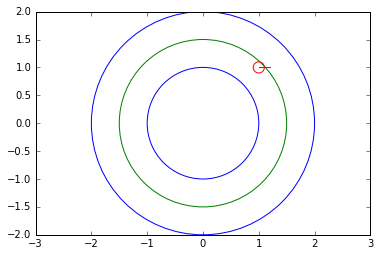

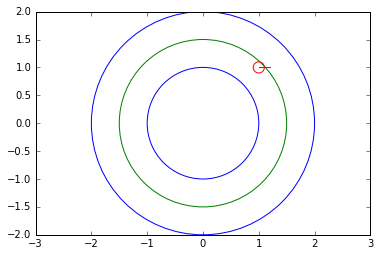

In [2]:
def show_state(x, y, angle):
    plt.gca().cla()
    fig=plt.figure(1)
    ax=fig.add_subplot(1,1,1)
    circ=plt.Circle((0,0), radius=1, color='b', fill=False)
    ax.add_patch(circ)
    circ2=plt.Circle((0,0), radius=2, color='b', fill=False)
    ax.add_patch(circ2)
    circ_center=plt.Circle((0,0), radius=1.5, color='g', fill=False)
    ax.add_patch(circ_center)
    agent=plt.Circle((x,y), radius=0.1, color='r', fill=False)
    ax.add_patch(agent)
    plt.plot([x, x + math.cos(angle)*0.2], [y, y + math.sin(angle)*0.2], linestyle='-', color='r')
    plt.axis('equal')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
x, y, angle = 1, 1, 0
show_state(x, y, angle)

In [3]:
def update_state(x, y, angle, velocity, angle_speed, TIME_STEP):
    x = x + velocity * math.cos(angle) * TIME_STEP
    y = y + velocity * math.sin(angle) * TIME_STEP
    angle = angle + angle_speed * TIME_STEP
    return x, y, angle

In [4]:
def state_is_end(x, y, angle):
    if math.sqrt(x**2 + y**2) < 1 or math.sqrt(x**2 + y**2) > 2:
        return True
    else:
        return False

In [5]:
def get_simple_action():
    velocity = 0.1
    angle_speed = math.pi * 0.1
    return velocity, angle_speed

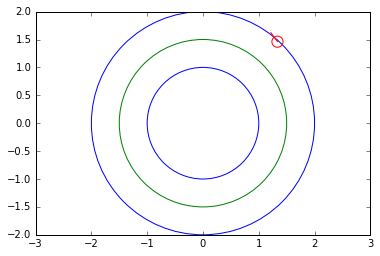

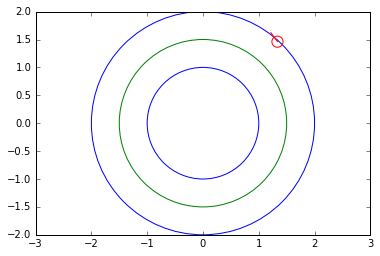

In [6]:
def simple_simulation():
    TIME_STEP = 1 # Discrete approximation time step for the continuous game
    x, y, angle = 1, 1, 0 # Robot state
    for i in range(100):
        show_state(x, y, angle)
        velocity, angle_speed = get_simple_action()
        x, y, angle = update_state(x, y, angle, velocity, angle_speed, TIME_STEP)
        if state_is_end(x, y, angle):
            break

simple_simulation()

In [7]:
def get_reward(x, y, angle, velocity, TIMESTEP):
    sin_global_angle = y / math.sqrt(x**2 + y**2)
    cos_global_angle = x / math.sqrt(x**2 + y**2)
    move_distance = velocity * TIMESTEP
    reward_speed = move_distance * (sin_global_angle * math.cos(angle) - cos_global_angle * math.sin(angle))
    reward_dist = - abs(math.sqrt(x**2 + y**2) - 1.5)
    reward = reward_speed + reward_dist
    logging.info('reward_speed: %.4f, reward_dist: %.4f, reward: %.4f', reward_speed, reward_dist, reward)
    return reward

x, y, angle, velocity, TIMESTEP = 1, 1, 0, 0.1, 1
reward = get_reward(x, y, angle, velocity, TIMESTEP)

In [8]:
def state_to_feature(x, y, angle):
    dist_to_center = math.sqrt(x**2 + y**2) - 1.5
    sin_global_angle = y / math.sqrt(x**2 + y**2)
    cos_global_angle = x / math.sqrt(x**2 + y**2)
    dist_to_angle1 = sin_global_angle * math.cos(angle) - cos_global_angle * math.sin(angle)
    dist_to_angle2 = cos_global_angle * math.cos(angle) + sin_global_angle * math.sin(angle)
    logging.info('dist_to_center: %.4f, dist_to_angle: %.4f, %.4f', dist_to_center, dist_to_angle1, dist_to_angle2)
    feature = np.array([dist_to_center, dist_to_angle1, dist_to_angle2, 1]) # Last dimenion is for bias
    return feature

x, y, angle = 1, 1, 0
feature = state_to_feature(x, y, angle)

In [9]:
def initialize_param(feature_dim, output_dim):
    weight = np.random.normal(0, 1.0, (feature_dim, output_dim))
    return weight

weight = initialize_param(3+1, 2)
print weight

[[-0.18698577 -0.76513938]
 [ 1.19811633  0.2782476 ]
 [-1.2099248   0.84159396]
 [-0.4081695   1.16645785]]


In [10]:
def get_q_value(feature, weight):
    q_value = np.dot(feature, weight)
    logging.info('q_value: [%.4f, %.4f]', q_value[0], q_value[1])
    return q_value

x, y, angle = 1, 1, 0
feature = state_to_feature(x, y, angle)
weight = initialize_param(3+1, 2)
q_value = get_q_value(feature, weight)

In [14]:
def get_max_q_action(q_value):
    max_q_value = q_value.max()
    max_action = q_value.argmax()
    logging.info('max_q_value: %.4f, max_action: %d', max_q_value, max_action)
    return max_q_value, max_action

x, y, angle = 1, 1, 0
feature = state_to_feature(x, y, angle)
weight = initialize_param(3+1, 2)
q_value = get_q_value(feature, weight)
max_q_value, max_action = get_max_q_action(q_value)

In [11]:
def action_to_physics(action):
    velocity = 0.1
    if action == 0:
        angle_speed = math.pi * 0.1
    else:
        angle_speed = - math.pi * 0.1
    logging.info('velocity: %.4f, angle_speed: %.4f', velocity, angle_speed)
    return velocity, angle_speed

action_to_physics(0)

(0.1, 0.3141592653589793)

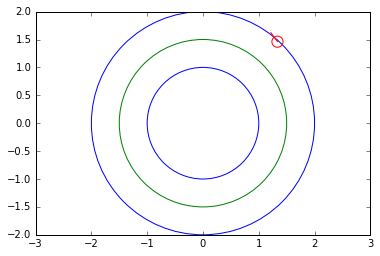

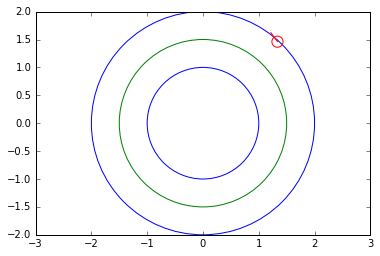

In [15]:
def q_simulation():
    TIME_STEP = 1 # Discrete approximation time step for the continuous game
    discount_factor = 0.9 # Discounted factor
    for iteration in range(5):
        logging.info('starting iteration %d', iteration)
        x, y, angle = 1, 1, 0 # Robot state
        weight = initialize_param(3+1, 2)
        cumulative_reward, discount = 0, 1
        for i in range(100):
            show_state(x, y, angle)
            feature = state_to_feature(x, y, angle)
            q_value = get_q_value(feature, weight)
            max_q_value, max_action = get_max_q_action(q_value)
            velocity, angle_speed = action_to_physics(max_action)
            x, y, angle = update_state(x, y, angle, velocity, angle_speed, TIME_STEP)
            reward = get_reward(x, y, angle, velocity, TIME_STEP)
            cumulative_reward = cumulative_reward + discount * reward
            discount = discount * discount_factor
            logging.info('cumulative reward: %.4f', cumulative_reward)
            if state_is_end(x, y, angle):
                break

q_simulation()

In [16]:
def explore_exploit(action, exploration_rate):
    if random.random() < exploration_rate: # Exploration
        if random.random() < 1.0/2:
            new_action = 0
        else:
            new_action = 1
    else: # Exploitation
        new_action = action
    logging.info('action: %.4f, action after exploration: %.4f', action, new_action)
    return new_action

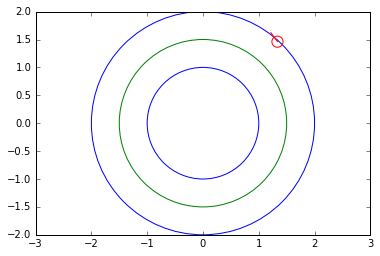

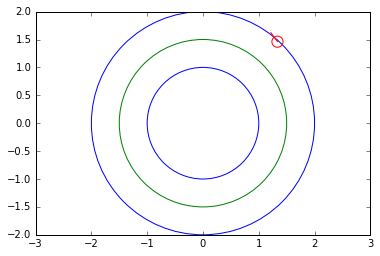

In [17]:
def q_explore_simulation():
    TIME_STEP = 1 # Discrete approximation time step for the continuous game
    exploration_rate = 0.5 # Exploration rate
    discount_factor = 0.9 # Discounted factor
    for iteration in range(5):
        logging.info('starting iteration %d', iteration)
        x, y, angle = 1, 1, 0 # Robot state
        weight = initialize_param(3+1, 2)
        cumulative_reward, discount = 0, 1
        for i in range(100):
            show_state(x, y, angle)
            feature = state_to_feature(x, y, angle)
            q_value = get_q_value(feature, weight)
            max_q_value, max_action = get_max_q_action(q_value)
            action = explore_exploit(max_action, exploration_rate)
            velocity, angle_speed = action_to_physics(action)
            x, y, angle = update_state(x, y, angle, velocity, angle_speed, TIME_STEP)
            reward = get_reward(x, y, angle, velocity, TIME_STEP)
            cumulative_reward = cumulative_reward + discount * reward
            discount = discount * discount_factor
            logging.info('cumulative reward: %.4f', cumulative_reward)
            if state_is_end(x, y, angle):
                break

q_explore_simulation()

In [18]:
def update_weight(weight, feature, q_value, action, gt_q_value):
    learning_rate = 0.01
    delta = q_value[action] - gt_q_value
    delta_weight = delta * feature
    weight[:, action] = weight[:, action] - learning_rate * delta_weight
    return weight

In [19]:
def compute_loss(q_value, action, gt_q_value):
    loss = (q_value[action] - gt_q_value)**2
    logging.info('loss: %.4f', loss)
    return loss

KeyboardInterrupt: 

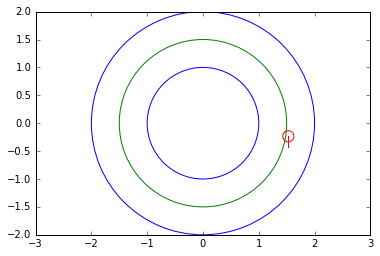

In [20]:
def q_learn():
    TIME_STEP = 1 # Discrete approximation time step for the continuous game
    TRAIN_ITER = 100 # Number of training iterations
    exploration_rate = np.linspace(1.0, 0.1, TRAIN_ITER)
    discount_factor = 0.9 # Discounted factor
    weight = initialize_param(3+1, 2)
    for i in range(TRAIN_ITER):
        logging.info('starting iteration %d', i)
        x, y, angle = 1, 1, 0 # Robot state       
        cumulative_reward, discount = 0, 1
        while True:
            show_state(x, y, angle)
            feature = state_to_feature(x, y, angle)
            q_value = get_q_value(feature, weight)
            max_q_value, max_action = get_max_q_action(q_value)
            action = explore_exploit(max_action, exploration_rate[i])
            velocity, angle_speed = action_to_physics(action)
            x, y, angle = update_state(x, y, angle, velocity, angle_speed, TIME_STEP)
            reward = get_reward(x, y, angle, velocity, TIME_STEP)
            cumulative_reward = cumulative_reward + discount * reward
            discount = discount * discount_factor
            logging.info('exploration rate: %.4f, cumulative reward: %.4f', exploration_rate[i], cumulative_reward)
            if state_is_end(x, y, angle):
                break
            next_feature = state_to_feature(x, y, angle)
            next_q_value = get_q_value(next_feature, weight)
            next_max_q_value, next_max_action = get_max_q_action(next_q_value)
            gt_q_value = reward + discount_factor * next_max_q_value
            loss = compute_loss(q_value, action, gt_q_value)
            weight = update_weight(weight, feature, q_value, action, gt_q_value)
    return weight

weight = q_learn()
print weight

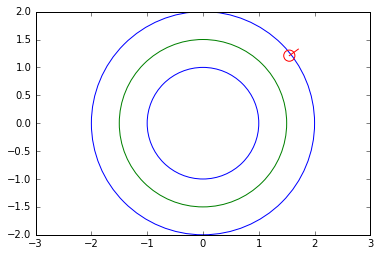

INFO:root:dist_to_center: 0.4643, dist_to_angle: 0.0355, 0.9994
INFO:root:q_value: [-0.7936, -0.4880]
INFO:root:max_q_value: -0.4880, max_action: 1
INFO:root:action: 1.0000, action after exploration: 1.0000
INFO:root:velocity: 0.1000, angle_speed: -0.3142
INFO:root:reward_speed: 0.0341, reward_dist: -0.5642, reward: -0.5301
INFO:root:cumulative reward: -1.1150


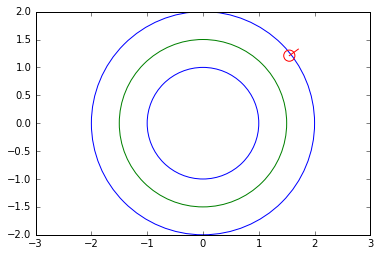

In [120]:
def q_test(weight):
    TIME_STEP = 1 # Discrete approximation time step for the continuous game
    exploration_rate = 0.1 # Exploration rate
    discount_factor = 0.9 # Discounted factor
    TEST_ITER = 5 # Number of training iterations
    for iteration in range(TEST_ITER):
        logging.info('starting iteration %d', iteration)
        x, y, angle = 1, 1, 0 # Robot state
        cumulative_reward, discount = 0, 1
        while True:
            show_state(x, y, angle)
            feature = state_to_feature(x, y, angle)
            q_value = get_q_value(feature, weight)
            max_q_value, max_action = get_max_q_action(q_value)
            action = explore_exploit(max_action, exploration_rate)
            velocity, angle_speed = action_to_physics(action)
            x, y, angle = update_state(x, y, angle, velocity, angle_speed, TIME_STEP)
            reward = get_reward(x, y, angle, velocity, TIME_STEP)
            cumulative_reward = cumulative_reward + discount * reward
            discount = discount * discount_factor
            logging.info('cumulative reward: %.4f', cumulative_reward)
            if state_is_end(x, y, angle):
                break

q_test(weight)